<a href="https://colab.research.google.com/github/Intertangler/public_tools/blob/main/DATE_TITLE_experimental_designipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions for Users:
- run the first cell, then move on to the next cell and enter parameters:
### Title and Description:
Fill in the title and description of your experiment.
Hypotheses: List all hypotheses you wish to test. Add or remove placeholders as needed.
### Priors:
Enter your initial beliefs about the likelihood of each hypothesis. Ensure they sum to 1.
### Result Descriptions:
Describe each potential result of the experiment. Include unforeseen possibilities.
### Result Probabilities:
Fill in the probability matrix based on how likely each result is under each hypothesis. Ensure that each row sums up to 1.

In [1]:
"""
RUN THIS CELL FIRST
defines functions, then move on to the next cell
"""
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def entropy(probabilities):
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log(probabilities))

def create_probability_bar(probability, bar_length=20):
    filled_length = int(round(probability * bar_length))
    empty_length = bar_length - filled_length
    filled_bar = '▓' * filled_length
    empty_bar = '░' * empty_length
    return filled_bar + empty_bar

def information_gain_for_result(priors, result_probabilities, result_index):
    prior_entropy = entropy(priors)
    posterior_probs = result_probabilities[:, result_index] * priors / np.dot(result_probabilities[:, result_index], priors)
    posterior_entropy = entropy(posterior_probs)
    return prior_entropy - posterior_entropy
def expected_information_gain(priors, result_probabilities):
    # Calculate the expected information gain
    prior_entropy = entropy(priors)
    weighted_posterior_entropies = []
    for i in range(result_probabilities.shape[1]):
        posterior_probs = result_probabilities[:, i] * priors / np.dot(result_probabilities[:, i], priors)
        posterior_entropy = entropy(posterior_probs)
        weighted_posterior_entropies.append(np.dot(result_probabilities[:, i], priors) * posterior_entropy)
    expected_posterior_entropy = sum(weighted_posterior_entropies)
    return prior_entropy - expected_posterior_entropy

def balance_score(result_probabilities, priors):
    result_probs_transposed = result_probabilities.T
    expected_result_probs = np.dot(result_probs_transposed, priors)
    return np.std(expected_result_probs)

def generate_report(experiment_title, experiment_description, hypotheses, priors, results, probabilities):
    # Convert probabilities dictionary to a matrix for calculations
    prob_matrix = np.array([probabilities[hypo] for hypo in hypotheses])

    # Prepare the report string
    report_string = f"===={experiment_title}: Bayesian Experimental Design Input Parameters==== \n"
    report_string += f"=====Experiment description:=====\n{experiment_description}\n"

    # Calculate EIG and balance score
    eig = expected_information_gain(priors, prob_matrix)
    balance = balance_score(prob_matrix, priors)

    # Include EIG and balance score in the report
    report_string += f"\n Expected Information Gain: {eig:.3f}\n"
    report_string += f" Balance Score: {balance:.3f}\n"

    # Hypotheses and Priors
    report_string += "\n=====Hypotheses and their Prior Probabilities:=====\n"
    for hypo in hypotheses:
        full_description = hypothesis_descriptions[hypo]
        prior = priors[hypotheses.index(hypo)]
        bar = create_probability_bar(prior)
        report_string += f"*{full_description} (Prior: {prior:.2f}): {bar}\n"

    # Result Probabilities
    report_string += "\n=====Results and Their Probabilities:=====\n"
    for result in results:
        full_description = result_descriptions[result]
        report_string += f"**{full_description}:\n"
        for hypo in hypotheses:
            probability = probabilities[hypo][results.index(result)]
            bar = create_probability_bar(probability)
            hypo_description = hypothesis_descriptions[hypo]
            report_string += f"***Probability given {hypo_description}: {probability:.2f} {bar}\n"


    # Posterior Report  Bayes' Theorem
    report_string += "\n====Posterior Report for Different Results====\n"
    for i, result in enumerate(results):
        info_gain = information_gain_for_result(priors, prob_matrix, i)
        report_string += f"\n*If Result {result} Occurs (Information Gain: {info_gain:.3f}):\n"
        for j, hypo in enumerate(hypotheses):
            updated_probability = prob_matrix[j, i] * priors[j] / np.dot(prob_matrix[:, i], priors)
            prior_bar = create_probability_bar(priors[j])
            posterior_bar = create_probability_bar(updated_probability)

            report_string += f"**Hypothesis {j+1} ({hypo}): "
            report_string += f"<math>P(H_{j+1}|R_{i+1}) = \\frac{{P(R_{i+1}|H_{j+1}) \\cdot P(H_{j+1})}}{{P(R_{i+1})}}</math>\n"
            report_string += f"***PRIORPROB: {prior_bar}\n"
            report_string += f"***POSTERIOR: {posterior_bar}\n"

    return report_string



def generate_visualization(hypotheses,priors,probabilities,results):
    G = nx.DiGraph()
    node_positions = {}
    node_labels = {}
    for i, (hypo, prior) in enumerate(zip(hypotheses, priors)):
        G.add_node(hypo, size=prior*3000, color='cyan')
        node_positions[hypo] = (0, i * (len(results) + 1))
        node_labels[hypo] = hypo + "\n" + str(prior * 100) + "%"

    for i, hypo in enumerate(hypotheses):
        hypo_prior = priors[i]
        for j, result in enumerate(results):
            node = f"{result}{i+1}"  # Node names include hypothesis index
            result_prob = probabilities[hypo][j]
            weighted_prob = hypo_prior * result_prob
            G.add_node(node, size=weighted_prob * 3000, color='magenta')
            node_positions[node] = (1, i * (len(results) + 1) + j)
            node_labels[node] = node  # Use result name and index for label
    edge_labels = {}
    for i, hypo in enumerate(hypotheses):
        for j, result in enumerate(results):
            node = f"{result}{i+1}"
            G.add_edge(hypo, node, weight=probabilities[hypo][j])
            edge_labels[(hypo, node)] = f"{probabilities[hypo][j]*100:.0f}%"
    plt.figure(figsize=(4, len(hypotheses)*len(results)))
    nx.draw_networkx_nodes(G, node_positions, node_size=[data['size'] for node, data in G.nodes(data=True)],
                          node_color=[data['color'] for node, data in G.nodes(data=True)])
    nx.draw_networkx_edges(G, node_positions, width=2)
    nx.draw_networkx_labels(G, node_positions, labels=node_labels)

    nx.draw_networkx_edge_labels(G, node_positions, edge_labels=edge_labels)
    for node, data in G.nodes(data=True):
        if node not in hypotheses:
            x, y = node_positions[node]
            plt.text(x+0.1, y, f"{data['size']/3000*100:.1f}%", horizontalalignment='left', verticalalignment='center')
    plt.axis('off')
    plt.show()

def calculate_and_draw_posterior_updates(hypotheses, priors, result_probabilities, result_name):

    observed_index = results.index(result_name)
    unnormalized_posteriors = [priors[i] * result_probabilities[i][observed_index] for i in range(len(hypotheses))]
    normalization_constant = sum(unnormalized_posteriors)
    posteriors = [p / normalization_constant for p in unnormalized_posteriors]
    G = nx.DiGraph()
    pos = {}
    node_labels = {}
    edge_labels = {}
    for i, (hypo, prior) in enumerate(zip(hypotheses, priors)):
        G.add_node(hypo, size=prior*3000, color='cyan')
        pos[hypo] = (0, -i)
        node_labels[hypo] = hypo + "\n" + str(prior * 100) + "%"
        result_node = f"{result_name}_{i}"
        G.add_node(result_node, size=posteriors[i]*3000, color='magenta')
        pos[result_node] = (2, -i)
        node_labels[result_node] = f"{result_name}_{i}"
        G.add_edge(hypo, result_node, weight=result_probabilities[i][observed_index])
        edge_labels[(hypo, result_node)] = f"{result_probabilities[i][observed_index]*100:.0f}%"

    plt.figure(figsize=(4, 4))
    nx.draw_networkx_nodes(G, pos, node_size=[data['size'] for node, data in G.nodes(data=True)],
                           node_color=[data['color'] for node, data in G.nodes(data=True)])
    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_labels(G, pos, labels=node_labels)
    for i, posterior in enumerate(posteriors):
        result_node = f"{result_name}_{i}"
        x, y = pos[result_node]
        plt.text(x+0.25, y, f"{posterior*100:.1f}%", fontsize=10, verticalalignment='center', horizontalalignment='left')

    plt.axis('off')
    plt.show()


## example input parameters

====Example Experiment Title: Bayesian Experimental Design Input Parameters==== 
=====Experiment description:=====
This is an example experiment description.

 Expected Information Gain: 0.109
 Balance Score: 0.056

=====Hypotheses and their Prior Probabilities:=====
*description (Prior: 0.30): ▓▓▓▓▓▓░░░░░░░░░░░░░░
*description (Prior: 0.50): ▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░
*description (Prior: 0.20): ▓▓▓▓░░░░░░░░░░░░░░░░

=====Results and Their Probabilities:=====
**description:
***Probability given description: 0.50 ▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░
***Probability given description: 0.20 ▓▓▓▓░░░░░░░░░░░░░░░░
***Probability given description: 0.30 ▓▓▓▓▓▓░░░░░░░░░░░░░░
**description:
***Probability given description: 0.40 ▓▓▓▓▓▓▓▓░░░░░░░░░░░░
***Probability given description: 0.20 ▓▓▓▓░░░░░░░░░░░░░░░░
***Probability given description: 0.30 ▓▓▓▓▓▓░░░░░░░░░░░░░░
**description:
***Probability given description: 0.10 ▓▓░░░░░░░░░░░░░░░░░░
***Probability given description: 0.60 ▓▓▓▓▓▓▓▓▓▓▓▓░░░░░░░░
***Probability g

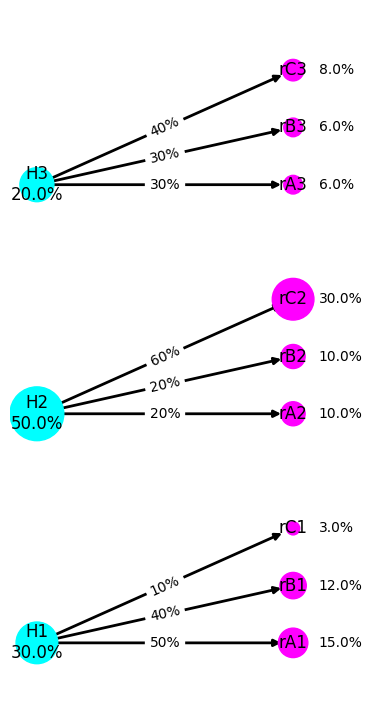

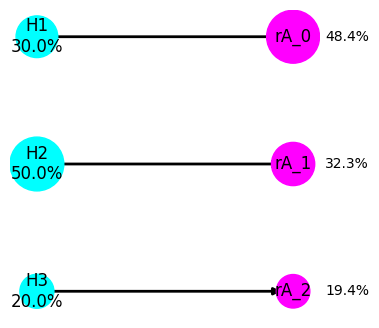

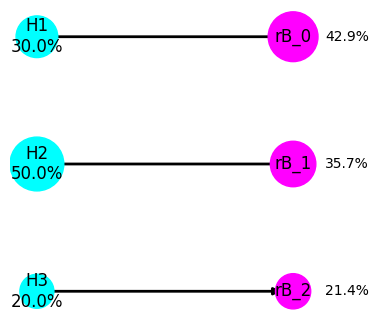

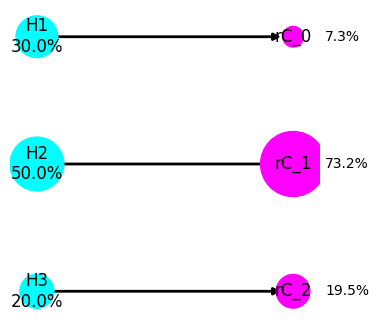

In [24]:
# parameters
experiment_title = "Example Experiment Title"
experiment_description = "This is an example experiment description."
hypotheses = ["H1", "H2", "H3"]
priors = np.array([0.3, 0.5, 0.2])
results = ["rA", "rB", "rC"]
probabilities = {
    'H1': [0.5, 0.4, 0.1],
    'H2': [0.2, 0.2, 0.6],
    'H3': [0.3, 0.3, 0.4]
}
# descriptions for hypotheses and results
hypothesis_descriptions = {
    "H1": "description",
    "H2": "description",
    "H3": "description"
}

result_descriptions = {
    "rA": "description",
    "rB": "description",
    "rC": "description"
}
# Generate the report
report = generate_report(experiment_title, experiment_description, hypotheses, priors, results, probabilities)
print(report)

generate_visualization(hypotheses,priors,probabilities,results)
for result in results:
    calculate_and_draw_posterior_updates(hypotheses, priors, np.array(list(probabilities.values())), result)


====Surfactant Influence on Microarray Spot Formation: Bayesian Experimental Design Input Parameters==== 
=====Experiment description:=====
This experiment aims to understand the impact of surfactant on microarray spot formation, particularly focusing on the avoidance of the coffee ring effect.

 Expected Information Gain: 0.096
 Balance Score: 0.025

=====Hypotheses and their Prior Probabilities:=====
*Surfactant reduces surface tension gradients causing the coffee ring effect (Prior: 0.20): ▓▓▓▓░░░░░░░░░░░░░░░░
*Surfactant promotes uniform particle distribution by steric hindrance (Prior: 0.20): ▓▓▓▓░░░░░░░░░░░░░░░░
*Evaporation rate is the dominant factor regardless of surfactant presence (Prior: 0.20): ▓▓▓▓░░░░░░░░░░░░░░░░
*Particle interactions are more significant than surfactant effects (Prior: 0.20): ▓▓▓▓░░░░░░░░░░░░░░░░
*Surfactant introduces new complex fluid dynamics altering deposition (Prior: 0.20): ▓▓▓▓░░░░░░░░░░░░░░░░

=====Results and Their Probabilities:=====
**Distinc

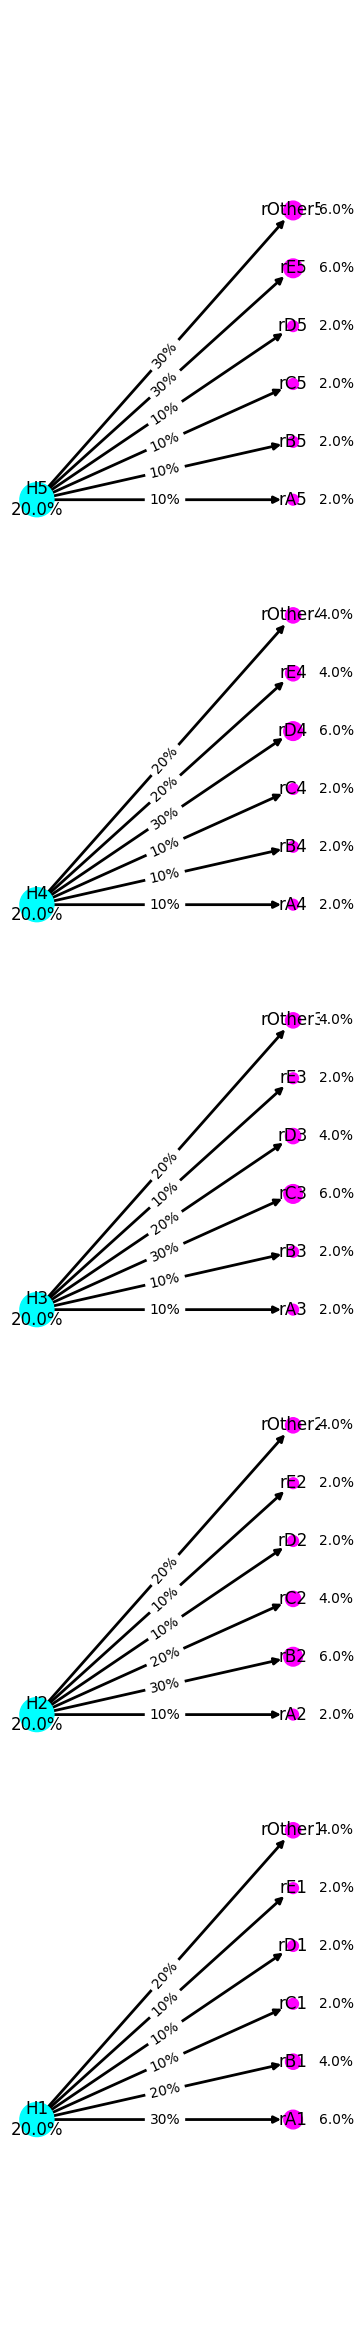

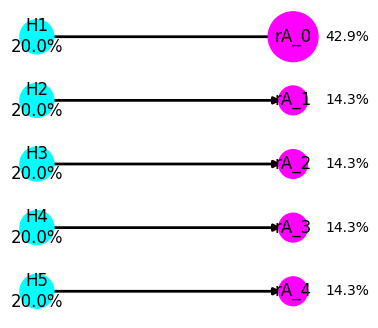

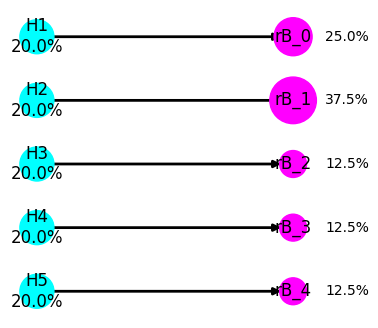

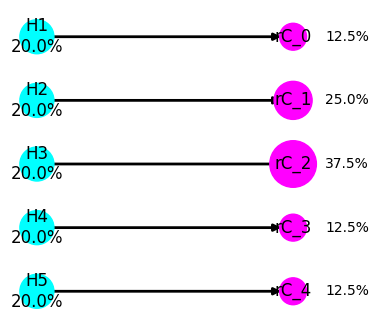

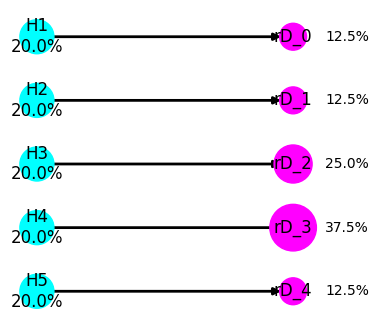

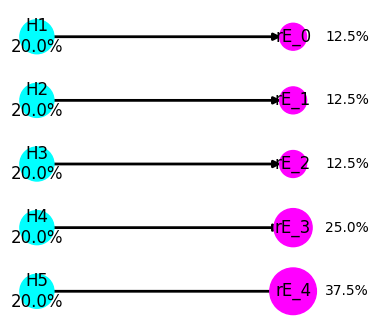

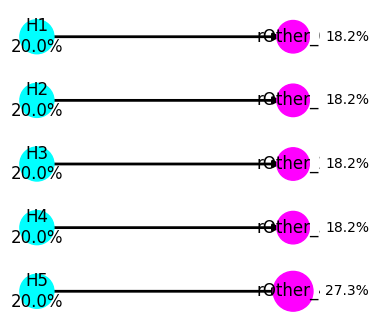

In [25]:
experiment_title = "Surfactant Influence on Microarray Spot Formation"
experiment_description = (
    "This experiment aims to understand the impact of surfactant on microarray spot formation, "
    "particularly focusing on the avoidance of the coffee ring effect."
)
hypotheses = ["H1", "H2", "H3", "H4", "H5"]

results = ["rA", "rB", "rC", "rD", "rE", "rOther"]
priors = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
probabilities = {
    'H1': [0.3, 0.2, 0.1, 0.1, 0.1, 0.2],
    'H2': [0.1, 0.3, 0.2, 0.1, 0.1, 0.2],
    'H3': [0.1, 0.1, 0.3, 0.2, 0.1, 0.2],
    'H4': [0.1, 0.1, 0.1, 0.3, 0.2, 0.2],
    'H5': [0.1, 0.1, 0.1, 0.1, 0.3, 0.3]
}

# Hypotheses descriptions
hypothesis_descriptions = {
    "H1": "Surfactant reduces surface tension gradients causing the coffee ring effect",
    "H2": "Surfactant promotes uniform particle distribution by steric hindrance",
    "H3": "Evaporation rate is the dominant factor regardless of surfactant presence",
    "H4": "Particle interactions are more significant than surfactant effects",
    "H5": "Surfactant introduces new complex fluid dynamics altering deposition"
}

# Results descriptions
result_descriptions = {
    "rA": "Distinct coffee ring effect",
    "rB": "Uniform deposition with no ring",
    "rC": "Slight ring with mostly uniform deposition",
    "rD": "Irregular deposition with clumping",
    "rE": "Deposition with gradient density",
    "rOther": "Other observed outcome"
}

# # Generate the report
report = generate_report(experiment_title, experiment_description, hypotheses, priors, results, probabilities)
print(report)

generate_visualization(hypotheses,priors,probabilities,results)
for result in results:
    calculate_and_draw_posterior_updates(hypotheses, priors, np.array(list(probabilities.values())), result)